# Лабораторная работа 1. Pandas, метод ближайших соседей и решающие деревья.

Соболева Дарья Михайловна

317 Группа

In [2]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.cross_validation import KFold
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Часть 1: Pandas

#### Ответьте на вопросы о данных по авиарейсам в США за январь-апрель 2008 года.

Данные: http://stat-computing.org/dataexpo/2009/2008.csv.bz2
(обратите внимание, что распаковывать этот файл не обязательно — функция `pandas.read_csv` умеет читать из архивов автоматически)

Описание: http://stat-computing.org/dataexpo/2009/the-data.html

1. Какая из причин отмены рейса (`CancellationCode`) была самой частой? (расшифровки кодов можно найти в описании данных)
2. Найдите среднее, минимальное и максимальное расстояние, пройденное самолетом.
3. Не выглядит ли подозрительным минимальное пройденное расстояние? В какие дни и на каких рейсах оно было? Какое расстояние было пройдено этими же рейсами в другие дни?
4. Из какого аэропорта было произведено больше всего вылетов? В каком городе он находится?
5. Найдите для каждого аэропорта среднее время полета (`AirTime`) по всем вылетевшим из него рейсам. Какой аэропорт имеет наибольшее значение этого показателя?
6. Найдите аэропорт, у которого наибольшая доля задержанных (`DepDelay > 0`) рейсов. Исключите при этом из рассмотрения аэропорты, из которых было отправлено меньше 1000 рейсов (используйте функцию `filter` после `groupby`).

In [39]:
#Проблемы с парсингом решились только так :(
!wget http://stat-computing.org/dataexpo/2009/2008.csv.bz2

--2016-10-30 12:06:48--  http://stat-computing.org/dataexpo/2009/2008.csv.bz2
Resolving stat-computing.org (stat-computing.org)... 54.231.169.43
Connecting to stat-computing.org (stat-computing.org)|54.231.169.43|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113753229 (108M) [application/x-bzip2]
Saving to: ‘2008.csv.bz2’

2008.csv.bz2        100%[===================>] 108,48M  2,10MB/s    in 2m 27s  

2016-10-30 12:09:16 (755 KB/s) - ‘2008.csv.bz2’ saved [113753229/113753229]



In [40]:
dfX = pd.read_csv('2008.csv.bz2')

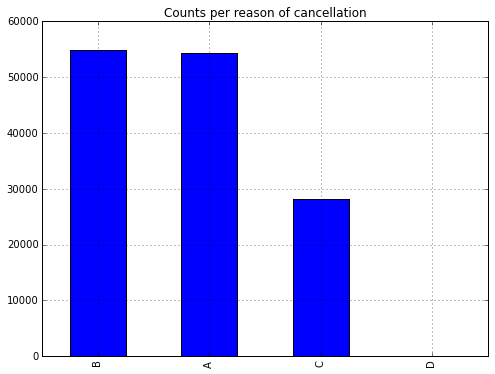

In [3]:
fig = figure(figsize=(8, 6))
dfX.CancellationCode.value_counts().plot(kind='bar')
grid()
title('Counts per reason of cancellation')
show()

Нет информации о причине отмены рейса типа D (security).
Чаще всего рейсы отменяли из-за погоды (B).

Посмотрим на статистику по пройденным расстояниям

In [4]:
dfX.Distance.describe()

count    7009728.000000
mean         726.387029
std          562.101803
min           11.000000
25%          325.000000
50%          581.000000
75%          954.000000
max         4962.000000
Name: Distance, dtype: float64

* Минимум - 11 миль
* Среднее - примерно 726 миль
* Максимум - 4962 мили

Минимум составляет всего 11 миль, возможно, мы имеем дело с вертолетом?:)
    
Посмотрим, кто и когда смог так умудриться.

In [5]:
dfX[dfX.Distance==dfX.Distance.min()].DayOfWeek

2547298    4
4392215    7
Name: DayOfWeek, dtype: int64

Эти авиарейсы были совершены в четверг и воскресенье

In [52]:
dfX[dfX.Distance==dfX.Distance.min()].FlightNum 

2547298    4988
4392215    5572
Name: FlightNum, dtype: int64

Рейсы с номерами 4988 и 5572

Посмотрим, как летали раньше эти подозрительные авиарейсы

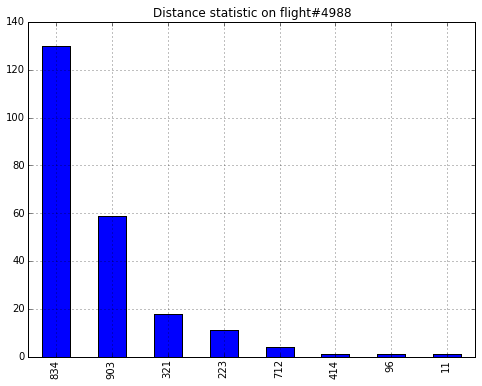

In [7]:
fig = figure(figsize=(8, 6))
dfX[dfX.FlightNum==4988].Distance.value_counts().plot(kind='bar')
grid()
title('Distance statistic on flight#4988')
show()

В среднем самолет пролетал около 770 миль, что мало, но не является столь подозрительным.

Посмотрим на место вылета и прилета.

In [8]:
dfX[(dfX.FlightNum==4988) & (dfX.Distance==11)].Origin

2547298    JFK
Name: Origin, dtype: object

In [9]:
dfX[(dfX.FlightNum==4988) & (dfX.Distance==11)].Dest

2547298    LGA
Name: Dest, dtype: object

In [45]:
#для удобства подгрузим информацию об аэропортах
air_info = pd.read_csv('http://stat-computing.org/dataexpo/2009/airports.csv')

In [11]:
air_info[air_info.iata=='JFK']

,iata,airport,city,state,country,lat,long
1915,JFK,John F Kennedy Intl,New York,NY,USA,40.639751,-73.778926


In [12]:
air_info[air_info.iata=='LGA']

,iata,airport,city,state,country,lat,long
2061,LGA,LaGuardia,New York,NY,USA,40.777243,-73.872609


Судя по кодам IATA, этот авиарейс осуществлялся из аэропорта Джона Кеннеди в ЛаГардию внутри Нью-Йорка.

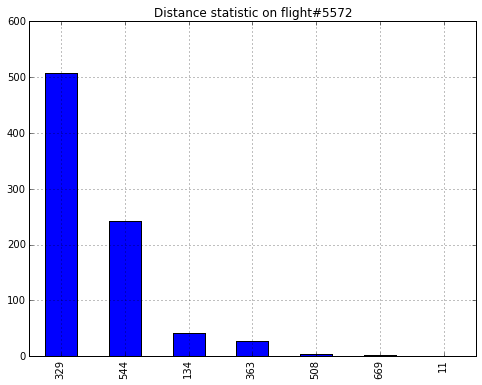

In [13]:
fig = figure(figsize=(8, 6))
dfX[dfX.FlightNum==5572].Distance.value_counts().plot(kind='bar')
grid()
title('Distance statistic on flight#5572')
show()

Эти рейсы гораздно чаще летали, но на более короткие расстояни

In [14]:
dfX[(dfX.FlightNum==5572) & (dfX.Distance==11)].Origin

4392215    JFK
Name: Origin, dtype: object

In [15]:
dfX[(dfX.FlightNum==5572) & (dfX.Distance==11)].Dest

4392215    LGA
Name: Dest, dtype: object

Значит, летали между аэропортами.

Посмотрим, из какого аэропорта чаще всего вылетали

In [16]:
dfX.Origin.describe()

count     7009728
unique        303
top           ATL
freq       414513
Name: Origin, dtype: object

In [17]:
air_info[air_info.iata=='ATL']

,iata,airport,city,state,country,lat,long
880,ATL,William B Hartsfield-Atlanta Intl,Atlanta,GA,USA,33.640444,-84.426944


По данным из вики, этот аэропорт, расположенный в Атланте, был провозглашен самым популярным по числу пассажирских перевозок и по 
количеству взлетов и посадок.
https://en.wikipedia.org/wiki/Hartsfield%E2%80%93Jackson_Atlanta_International_Airport

Посмотрим на статистику по каждому из аэропортов

In [19]:
mean_time = dfX.groupby('Origin')['AirTime'].mean().reset_index()
mean_time.head()

,Origin,AirTime
0,ABE,89.057518
1,ABI,36.789977
2,ABQ,91.657166
3,ABY,35.379759
4,ACK,50.692124


In [90]:
mean_time.ix[mean_time.AirTime.idxmax()]

Origin         SJU
AirTime    203.851
Name: 266, dtype: object

In [21]:
air_info[air_info.iata=='SJU']

,iata,airport,city,state,country,lat,long
2962,SJU,Luis Munoz Marin International,San Juan,PR,USA,18.439417,-66.001833


Международный аэропорт имени Луиса Муньоса Марина имеет самый высокий показатель среднего веремни полета по всем вылетавшим из него рейсов.

In [87]:
dfX_new = dfX.groupby('Origin').filter(lambda x: len(x) >= 1000)
df_delay = dfX_new[dfX_new.DepDelay > 0].Origin.value_counts().reset_index()
df_delay.columns = ['Origin', 'DepDelay_counts']

df = dfX_new.Origin.value_counts().reset_index()
df.columns = ['Origin', 'Counts']

df_delay = pd.merge(df_delay, df, how='left', on='Origin')

df_delay['Delay_freq'] = df_delay.DepDelay_counts /  df_delay.Counts
df_delay.ix[df_delay.Delay_freq.idxmax()]

Origin                  DAL
DepDelay_counts       31205
Counts                53928
Delay_freq         0.578642
Name: 23, dtype: object

In [82]:
air_info[air_info.iata=='DAL']

,iata,airport,city,state,country,lat,long
1247,DAL,Dallas Love,Dallas,TX,USA,32.847114,-96.851772


Наибольшая доля задерженных рейсов у аэропорта Даллас / Лав-Филд, расположенного в штате Техас

## Часть 2: метрические методы и категориальные признаки

In [3]:
from sklearn.cross_validation import train_test_split
from counts_success import counts_successes

def counts(data):
    X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0],
                                                    test_size=0.3, random_state=241)
    data_train = pd.concat([X_train, y_train], axis=1, join='inner')
    data_test  = pd.concat([X_test, y_test], axis=1, join='inner')
    
    target = 'ACTION'
    predictors = [col_name for col_name in data.columns if col_name != target]
    
    data_train_new, data_test_new = counts_successes(data_train, data_test, predictors, target)
    new_predictors = [col_name for col_name in data_train_new.columns \
                                           if col_name not in predictors and col_name!=target]
    return data_train_new, data_test_new, new_predictors

In [4]:
def counts_folds(data):
    X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0],
                                                       test_size=0.3, random_state=241)
    data_train = pd.concat([X_train, y_train], axis=1, join='inner')
    data_test  = pd.concat([X_test, y_test], axis=1, join='inner')
    kf = KFold(data_train.shape[0], 3)
    
    target = 'ACTION'
    predictors = [col_name for col_name in data.columns if col_name != target] 
    list_smooth = [col_name + '_smooth' for col_name in predictors]
    
    data_train_new, data_test_new, new_predictors = counts(data)
    norm_predictors = [col_name for col_name in new_predictors if col_name not in list_smooth]
    
    tmp = []
    for i, j in kf:
        _, data_new  = counts_successes(data_train.iloc[i], data_train.iloc[j],
                                         predictors, target)
        l = _.shape[0]
        for col_name in norm_predictors:
            data_new[col_name] /= l
        tmp.append(data_new)
    data_train_new = pd.concat([df for df in tmp])
    
    # Нормируем признаки на тесте
    l = data_train.shape[0]
    for col_name in norm_predictors:
        data_test_new[col_name] /= l
        
    return data_train_new, data_test_new, new_predictors

In [3]:
!wget https://www.dropbox.com/s/q6fbs1vvhd5kvek/amazon.csv

wget: /root/miniconda/envs/rep_py2/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /root/miniconda/envs/rep_py2/lib/libssl.so.1.0.0: no version information available (required by wget)
--2016-10-29 16:45:56--  https://www.dropbox.com/s/q6fbs1vvhd5kvek/amazon.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/Xl6lIXfQRBLBmXi3cc6KfdglMyp4NimL10ZsRvaEfTeKLqvPrtWoEPgxJ5Gyl4ql/file [following]
--2016-10-29 16:45:58--  https://dl.dropboxusercontent.com/content_link/Xl6lIXfQRBLBmXi3cc6KfdglMyp4NimL10ZsRvaEfTeKLqvPrtWoEPgxJ5Gyl4ql/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 45.58.69.101
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|45.58.69.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

Все дальнейшие эксперименты предлагается проводить на данных соревнования Amazon Employee Access Challenge: https://www.kaggle.com/c/amazon-employee-access-challenge

В данной задаче предлагается предсказать, будет ли одобрен запрос сотрудника на получение доступа к тому или иному ресурсу. Все признаки являются категориальными.

Для удобства данные можно загрузить по ссылке: https://www.dropbox.com/s/q6fbs1vvhd5kvek/amazon.csv

Сразу прочитаем данные и создадим разбиение на обучение и контроль:

In [5]:
data = pd.read_csv('amazon.csv')
data.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [24]:
data.shape

(32769, 10)

In [25]:
# доля положительных примеров
data.ACTION.mean()

0.94210992096188473

In [29]:
# число значений у признаков
for col_name in data.columns:
    print (col_name, len(data[col_name].unique()))

ACTION 2
RESOURCE 7518
MGR_ID 4243
ROLE_ROLLUP_1 128
ROLE_ROLLUP_2 177
ROLE_DEPTNAME 449
ROLE_TITLE 343
ROLE_FAMILY_DESC 2358
ROLE_FAMILY 67
ROLE_CODE 343


In [6]:
#Перекодируем значения каждого признака  от 0 до feature_n_unique_values
target = 'ACTION'
predictors = [col_name for col_name in data.columns if col_name != target]
encoder = preprocessing.LabelEncoder()
for col_name in predictors:
        data[col_name] = encoder.fit_transform(data[col_name])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0],
                                                    test_size=0.3, random_state=241)

#### 1. Реализуйте три функции расстояния на категориальных признаках, которые обсуждались на втором семинаре.

Проще всего будет определить метрики как [user-defined distance](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html), после чего воспользоваться реализацией kNN из sklearn (в этом случае используйте функцию predict_proba). Можно реализовать метод k ближайших соседей и самостоятально — в этом случае учитите, что он должен возвращать оценку вероятности, то есть отношение объектов первого класса среди соседей к числу соседей).

Постарайтесь уделить особое внимание эффективности кода — при реализации метрик "в лоб" вы можете столкнуться с очень большим временем выполнения.

#### Подсчитайте для каждой из метрик качество на тестовой выборке `X_test` при числе соседей $k = 10$. Мера качества — AUC-ROC.

#### Какая функция расстояния оказалась лучшей?

Воспользуемся собственной реализиацей всех нужных метрик

In [5]:
from metrics import Dist
dist = Dist(X_train)

Перевернем все в numpy.array для ускорения работы

In [13]:
X_train_arr, y_train_arr = X_train.as_matrix(),  y_train.as_matrix().astype(int)
X_test_arr, y_test_arr  = X_test.as_matrix(), y_test.as_matrix().astype(int)

Чтобы не скучать, будем слать себе сообщения о текущем состоянии дел)


In [ ]:
%%bash
git clone https://github.com/soboleva-daria/pyloggers.git
cd pyloggers/ && git pull

In [7]:
import sys
sys.path.insert(1,'pyloggers')
from telegram_logger import TelegramLogger
tl = TelegramLogger(name='knn', print_dual_logging=False)

In [ ]:
knn = KNeighborsClassifier(
    n_neighbors=10,
    metric=dist.ind_matches,
    algorithm='brute',
).fit(X_train_arr, y_train_arr)

scores = knn.predict_proba(X_test_arr[:1000, :])
tl.push('done0')

for i in range(1, 10):
    y_pred = knn.predict_proba(X_test_arr[i*1000: (i+1)*1000, :])
    scores = np.vstack((scores, y_pred))
    tl.push('done{}'.format(i))

In [9]:
results = {}
results['metric_ind_matches'] = {'AUC-ROC': roc_auc_score (y_test_arr, scores[:, 1])}

In [ ]:
knn = KNeighborsClassifier(
    n_neighbors=10,
    metric=dist.smooth_ind_matches,
    algorithm='brute',
).fit(X_train_arr, y_train_arr)

scores = knn.predict_proba(X_test_arr[:1000, :])
tl.push('done0')

for i in range(1, 10):
    y_pred = knn.predict_proba(X_test_arr[i*1000: (i+1)*1000, :])
    scores = np.vstack((scores, y_pred))
    tl.push('done{}'.format(i))

In [22]:
results['metric_smooth_ind_matches'] = {'AUC-ROC': roc_auc_score (y_test_arr, scores[:, 1])}

In [ ]:
knn = KNeighborsClassifier(
    n_neighbors=10,
    metric=dist.log_ind_matches,
    algorithm='brute'
).fit(X_train_arr, y_train_arr)

scores = knn.predict_proba(X_test_arr[:1000, :])
tl.push('done0')

for i in range(1, 10):
    y_pred = knn.predict_proba(X_test_arr[i*1000: (i+1)*1000, :])
    scores = np.vstack((scores, y_pred))
    tl.push('done{}'.format(i))

In [29]:
results['metric_log_ind_matches'] = {'AUC-ROC': roc_auc_score (y_test_arr, scores[:, 1])}

In [45]:
pd.DataFrame(results).T

,AUC-ROC
metric_ind_matches,0.829499
metric_log_ind_matches,0.809719
metric_smooth_ind_matches,0.833112


Лучшим оказалась модель, использующая сглаженный индикатор совпадения.

#### 2 (бонус). Подберите лучшее (на тестовой выборке) число соседей $k$ для каждой из функций расстояния. Какое наилучшее качество удалось получить?

Для подбора можно использовать любые средства из sklearn.

Подберем k для каждой метрики.
Так как у нас задача бинарной классификации, имеет смысл брать нечетный k

In [5]:
results_k = {}

In [ ]:
for k in range(3,11,2):
    knn = KNeighborsClassifier(
          n_neighbors=k,
          metric=dist.ind_matches,
          algorithm='brute',
    ).fit(X_train_arr, y_train_arr)
    
    results_k['n_neighbors={}'.format(k)] = {'AUC-ROC': roc_auc_score (y_test_arr, knn.predict_proba(X_test_arr)[:, 1])}
    tl.push('done{}'.format(k))

In [44]:
pd.DataFrame(results_k).T

,AUC-ROC
n_neighbors=3,0.796849
n_neighbors=5,0.825477
n_neighbors=7,0.836309
n_neighbors=9,0.831382


Модель с  k=7 оказалась лучшей

In [ ]:
for k in range(3,11,2):
    knn = KNeighborsClassifier(
          n_neighbors=k,
          metric=dist.smooth_ind_matches,
          algorithm='brute',
    ).fit(X_train_arr, y_train_arr)
    
    results_k['n_neighbors={}'.format(k)] = {'AUC-ROC': roc_auc_score (y_test_arr, knn.predict_proba(X_test_arr)[:, 1])}
    tl.push('done{}'.format(k))

In [46]:
pd.DataFrame(results_k).T

,AUC-ROC
n_neighbors=3,0.799776
n_neighbors=5,0.830632
n_neighbors=7,0.834261
n_neighbors=9,0.830936


Модель с k=7 снова оказалась лучшей

In [ ]:
for k in range(3,11,2):
    knn = KNeighborsClassifier(
          n_neighbors=k,
          metric=dist.log_ind_matches,
          algorithm='brute',
    ).fit(X_train_arr, y_train_arr)
    
    results_k['n_neighbors={}'.format(k)] = {'AUC-ROC': roc_auc_score (y_test_arr, knn.predict_proba(X_test_arr)[:, 1])}
    tl.push('done{}'.format(k))

In [47]:
pd.DataFrame(results_k).T

,AUC-ROC
n_neighbors=3,0.773867
n_neighbors=5,0.799875
n_neighbors=7,0.804365
n_neighbors=9,0.807482


k=9 дало лучший результат, необходимо оценить модель с k=11.

In [ ]:
k = 11
knn = KNeighborsClassifier(
          n_neighbors=k,
          metric=dist.log_ind_matches,
          algorithm='brute',
    ).fit(X_train_arr, y_train_arr)
    
results_k['n_neighbors={}'.format(k)] = {'AUC-ROC': roc_auc_score (y_test_arr, knn.predict_proba(X_test_arr)[:, 1])}
tl.push('done{}'.format(k))

In [44]:
pd.DataFrame(results_k).T

,AUC-ROC
n_neighbors=11,0.807443
n_neighbors=3,0.773867
n_neighbors=5,0.799875
n_neighbors=7,0.804365
n_neighbors=9,0.807482


Модель с k=9 оказалась лучшей.

Лучшей по-прежнему остается модель, использующая сглаженный индикатор совпадения.

Подобран k=7, при котором AUC-ROC=0.834261

#### 3. Реализуйте счетчики (http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx), которые заменят категориальные признаки на вещественные.

А именно, каждый категориальный признак нужно заменить на три: 
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
2. Число `successes` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
3. Сглаженное отношение двух предыдущих величин: (`successes` + 1) / (`counts` + 2).

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `successes` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанные по всей обучающей выборке. Реализуйте и такой вариант. Можно использовать $n = 3$.

#### Посчитайте на тесте AUC-ROC метода $k$ ближайших соседей с евклидовой метрикой для выборки, где категориальные признаки заменены на счетчики. Сравните по AUC-ROC два варианта формирования выборки — с фолдингом и без. Не забудьте подобрать наилучшее число соседей $k$.

Воспользуемся функцией counts, которая подсчитывает нужные признаки для трейна и теста.

Для теста информация берется из трейна!

In [ ]:
data_train_new, data_test_new, new_predictors = counts(data)

Подберем оптимальный k на тестовой выборке. Способ без фолдинга.

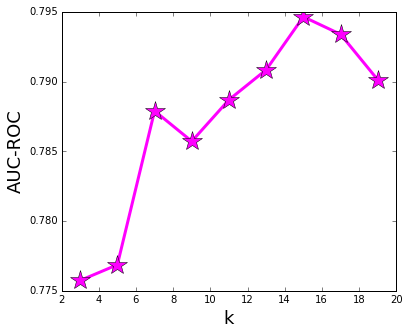

In [11]:
results_cv = []
plt.figure(figsize=(6,5))
plt.xlabel("k", fontsize = 18)
plt.ylabel('AUC-ROC', fontsize = 18)

k_list = list(range(3,21,2))
for k in k_list:
    knn = KNeighborsClassifier(
          n_neighbors=k,
          metric='euclidean',
          algorithm='brute',
    ).fit(data_train_new[new_predictors], data_train_new[target])
    
    results_cv.append(roc_auc_score (data_test_new[target], \
                                     knn.predict_proba(data_test_new[new_predictors])[:, 1]))
plot(k_list, results_cv, lw = 3, marker='*', markersize=20, color = 'magenta')
show()

В расммотренном диапазоне изменения параметра k выявили оптиум: k=15

Оценим вариант с фолдингом.

In [ ]:
data_train_new, data_test_new, new_predictors = counts_folds(data)

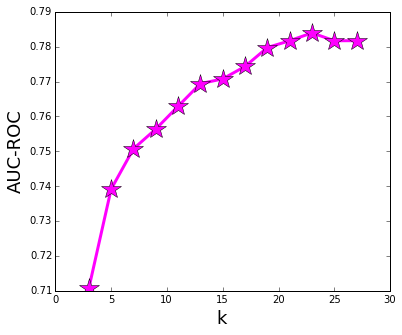

In [13]:
results_cv = []
plt.figure(figsize=(6,5))
plt.xlabel("k", fontsize = 18)
plt.ylabel('AUC-ROC', fontsize = 18)

k_list = list(range(3,29,2))
for k in k_list:
    knn = KNeighborsClassifier(
          n_neighbors=k,
          metric='euclidean',
          algorithm='brute',
    ).fit(data_train_new[new_predictors], data_train_new[target])
    
    results_cv.append(roc_auc_score (data_test_new[target], \
                                     knn.predict_proba(data_test_new[new_predictors])[:, 1]))
plot(k_list, results_cv, lw = 3, marker='*', markersize=20, color = 'magenta')
show()

Итак, оптиум достигается при k=23.

В целом обощающая способность улучшается, модель ведет себя более адекватно, чем без использования фолдинга.

#### 4. Добавьте в исходную выборку парные признаки — то есть для каждой пары $(f_i, f_j)$, $i < j$ исходных категориальных признаков добавьте новый категориальный признак $f_{ij}$, значение которого является конкатенацией значений $f_i$ и $f_j$ (желательно через какой-нибудь специальный символ во избежание коллизий). Посчитайте счетчики для этой выборки, найдите качество метода $k$ ближайших соседей с наилучшим $k$ (с фолдингом и без).

In [7]:
# Специальный символ #
data_new = data.copy()
columns = np.array(predictors)
for i, col_name in enumerate(columns):
    col_1 = data_new[col_name]
    for col_name_ in columns[i + 1:]:
        col_2 = data_new[col_name_]
        data_new[col_name + '#' + col_name_] = \
                        col_1.astype(str) + '#' + col_2.astype(str)
predictors = [col_name for col_name in data_new.columns if col_name != target]

Вариант без фолдинга

In [ ]:
data_train_new, data_test_new, new_predictors = counts(data_new)

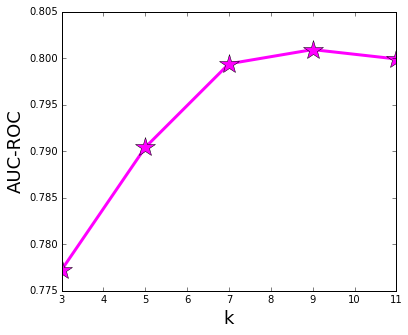

In [23]:
results_cv = []
plt.figure(figsize=(6,5))
plt.xlabel("k", fontsize = 18)
plt.ylabel('AUC-ROC', fontsize = 18)

k_list = list(range(3,13,2))
for k in k_list:
    knn = KNeighborsClassifier(
          n_neighbors=k,
          metric='euclidean',
          algorithm='brute',
    ).fit(data_train_new[new_predictors], data_train_new[target])
    
    results_cv.append(roc_auc_score (data_test_new[target], \
                                     knn.predict_proba(data_test_new[new_predictors])[:, 1]))
plot(k_list, results_cv, lw = 3, marker='*', markersize=20, color = 'magenta')
show()

Заметим, что качество стало лучше после добавления новых признаков.
Оптиум достигнут уже при k=9.

Посмотрим на фолдинг.

In [ ]:
data_train_new, data_test_new, new_predictors = counts_folds(data_new)

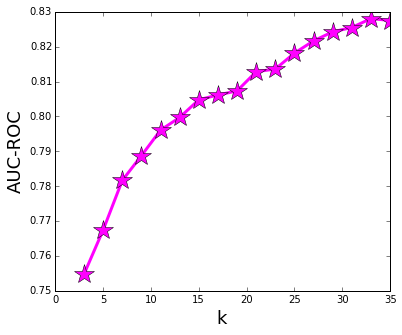

In [42]:
results_cv = []
plt.figure(figsize=(6,5))
plt.xlabel("k", fontsize = 18)
plt.ylabel('AUC-ROC', fontsize = 18)

k_list = list(range(3,37,2))
for k in k_list:
    knn = KNeighborsClassifier(
          n_neighbors=k,
          metric='euclidean',
          algorithm='brute',
    ).fit(data_train_new[new_predictors], data_train_new[target])
    
    results_cv.append(roc_auc_score (data_test_new[target], \
                                     knn.predict_proba(data_test_new[new_predictors])[:, 1]))
plot(k_list, results_cv, lw = 3, marker='*', markersize=20, color = 'magenta')
show()

Достигнут долгожданный локальный оптиум при k=33

## Часть 3: Решающие деревья и леса

#### 1. Возьмите из предыдущей части выборку с парными признаками, преобразованную с помощью счетчиков без фолдинга. Настройте решающее дерево, подобрав оптимальные значения параметров `max_depth` и `min_samples_leaf`. Какой наилучший AUC-ROC на контроле удалось получить?

In [8]:
def modelfit(alg, dtrain, dtest,  predictors, target):
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtest_predictions = alg.predict(dtest[predictors])
        
    #Print model report:
    print ("\nModel Report")
    print ("AUC (Train): %f" % roc_auc_score(dtrain[target], dtrain_predictions) )
    print ("AUC (Test): %f" %  roc_auc_score(dtest[target],   dtest_predictions ) )

In [30]:
def modelfit_xgb(alg, dtrain, dtest, predictors, target, 
                 useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
             metrics=['auc'], early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
        
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target], eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtest_predictions = alg.predict(dtest[predictors])
        
    #Print model report:
    print ("\nModel Report")
    print ("AUC (Train): %f" % roc_auc_score(dtrain[target], dtrain_predictions) )
    print ("AUC (Test): %f" %  roc_auc_score(dtest[target],   dtest_predictions ) )
    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV

In [11]:
data_train_new, data_test_new, new_predictors = counts(data_new)

Так как индекс Джини связан с AUC известной формулой ($Gini = 2 * AUCROC-1$).

In [100]:
dtr = DecisionTreeClassifier(max_depth=3, 
                             min_samples_leaf=1,
                             random_state=10,
                             criterion='gini'
                        )
modelfit(dtr, data_train_new, data_test_new, new_predictors, target)


Model Report
AUC (Train): 0.994406
AUC (Test): 0.534473


Видим, что модель сильно переобучена, попробуем уменьшить разрыв между ошибкой на тесте и трейне.

В виду того, что рассматривается задача с несбалансированными классами, min_samples_leaf
должен быть не очень большим.

Выберем лучшие параметры по кросс-валидации с 5 фолдами.

In [104]:
param_test1 = {'max_depth':list(range(3,10,1)),
              'min_samples_leaf':list(range(100,500,50))}

gsearch1 = GridSearchCV(estimator = DecisionTreeClassifier(random_state=10),
                                    param_grid = param_test1,
                                    scoring='roc_auc',
                                    n_jobs=4,
                                    cv=5) 
gsearch1.fit(data_train_new[new_predictors],data_train_new[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.99829, std: 0.00318, params: {'max_depth': 3, 'min_samples_leaf': 100},
  mean: 0.99809, std: 0.00319, params: {'max_depth': 3, 'min_samples_leaf': 150},
  mean: 0.99790, std: 0.00322, params: {'max_depth': 3, 'min_samples_leaf': 200},
  mean: 0.99842, std: 0.00173, params: {'max_depth': 3, 'min_samples_leaf': 250},
  mean: 0.99837, std: 0.00171, params: {'max_depth': 3, 'min_samples_leaf': 300},
  mean: 0.99739, std: 0.00128, params: {'max_depth': 3, 'min_samples_leaf': 350},
  mean: 0.99552, std: 0.00329, params: {'max_depth': 3, 'min_samples_leaf': 400},
  mean: 0.99690, std: 0.00118, params: {'max_depth': 3, 'min_samples_leaf': 450},
  mean: 0.99829, std: 0.00318, params: {'max_depth': 4, 'min_samples_leaf': 100},
  mean: 0.99811, std: 0.00320, params: {'max_depth': 4, 'min_samples_leaf': 150},
  mean: 0.99793, std: 0.00324, params: {'max_depth': 4, 'min_samples_leaf': 200},
  mean: 0.99844, std: 0.00175, params: {'max_depth': 4, 'min_samples_leaf': 250},
  mean: 0.99837,

In [23]:
param_test2 = {'min_samples_leaf':list(range(250,300,10))}

gsearch1 = GridSearchCV(estimator = DecisionTreeClassifier(random_state=10),
                                    param_grid = param_test2,
                                    scoring='roc_auc',
                                    n_jobs=4,
                                    cv=5, iid=False) 
gsearch1.fit(data_train_new[new_predictors],data_train_new[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.99844, std: 0.00175, params: {'min_samples_leaf': 250},
  mean: 0.99844, std: 0.00175, params: {'min_samples_leaf': 260},
  mean: 0.99806, std: 0.00163, params: {'min_samples_leaf': 270},
  mean: 0.99729, std: 0.00231, params: {'min_samples_leaf': 280},
  mean: 0.99843, std: 0.00174, params: {'min_samples_leaf': 290}],
 {'min_samples_leaf': 250},
 0.9984429434991442)

In [105]:
dtr = DecisionTreeClassifier(max_depth=4, 
                             min_samples_leaf=250,
                             random_state=10
                             
                            )
modelfit(dtr, data_train_new, data_test_new, new_predictors, target)


Model Report
AUC (Train): 0.992091
AUC (Test): 0.578082


Как видно, качество на тесте возросло, однако модель явно переобучена. Возможно, полезным будет обрезать признаки по важности,

что и попробуем сделать в следующих экспериментах.

#### 2. Настройте случайный лес, подобрав такое число деревьев `n_estimators`, при котором ошибка выходит на асимптоту. Какое качество на тестовой выборке он дает?

In [35]:
data_train_new, data_test_new, new_predictors = counts(data_new)

In [12]:
from xgboost.sklearn import XGBClassifier
import xgboost as xgb

Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 104



Model Report
AUC (Train): 0.999977
AUC (Test): 0.578461


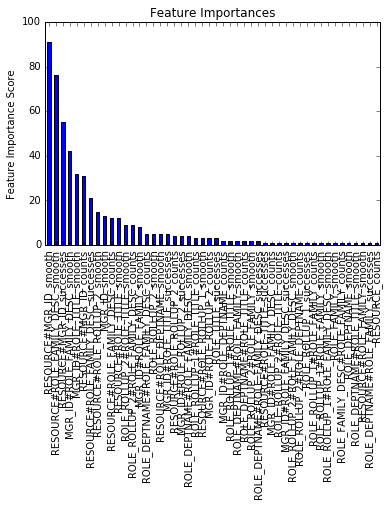

In [15]:
xgb1 = XGBClassifier(n_estimators=1000, seed=numpy.random.random([27]))

modelfit_xgb(xgb1, data_train_new, data_test_new, new_predictors, target)

Воспользовались собственным скриптом, который в начале подбирает n_estimators, при котором ошибка выходит на асимптоту,
а затем вычисляет ошибку на трейне и тесте.

Видно, что очень много незначительных признаков, до которых, скорее всего, руки классификатора даже не дошли.
Попробуем не использовать парные признаки.

Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 345



Model Report
AUC (Train): 0.895149
AUC (Test): 0.641709


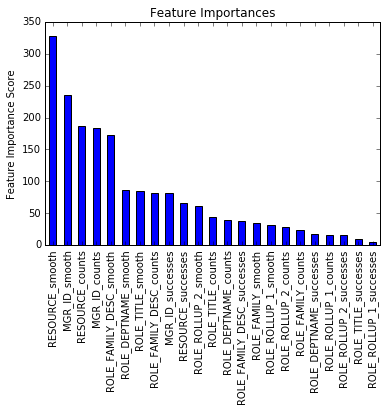

In [36]:
new_new_predictors = [col_name for col_name in new_predictors if '#' not in col_name]
xgb1 = XGBClassifier(n_estimators=1000, seed=numpy.random.random([27]))
modelfit_xgb(xgb1, data_train_new, data_test_new, new_new_predictors, target)

Как видно, разрыв между тестом и трейном стал меньше, а значит увеличилась обобщающая способность нашей модели.

#### 3. Возьмите выборку с парными признаками, для которой счетчики посчитаны с фолдингом. Обучите на ней случайный лес, подобрав число деревьев. Какое качество на тестовой выборке он дает? Чем вы можете объяснить изменение результата по сравнению с предыдущим пунктом?

In [26]:
data_train_new, data_test_new, new_predictors = counts_folds(data_new)

Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 325



Model Report
AUC (Train): 0.708750
AUC (Test): 0.660495


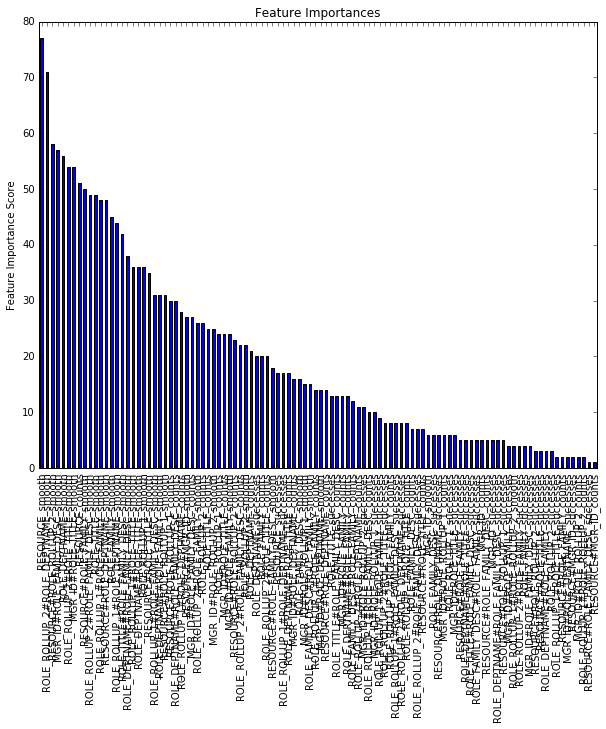

In [33]:
figure(figsize=(10,8))
xgb1 = XGBClassifier(n_estimators=1000, seed=numpy.random.random([27]))
modelfit_xgb(xgb1, data_train_new, data_test_new, new_predictors, target)

Качество на тесте возросло, обобщающая способность выше, для этого и применяли фолдинг!

---

Здесь вы можете поделиться своими мыслями о задании.

Задание понравилось, полезно было поработать над оптимизацией кода)

А здесь вставьте смешную картинку.

![](picture.jpg ?raw=true)

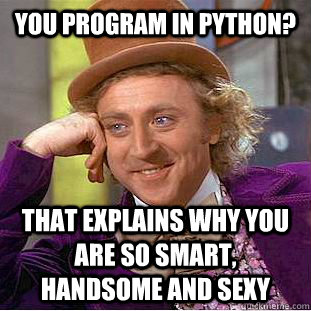

In [51]:
from IPython.display import Image
Image(filename='picture.jpg')

А здесь посоветуйте преподавателям хороший фильм или сериал.

Мне понравился фильм "Фирма" по роману Джона Гришэма с Томом Крузом в главной роли.

Фильм был выпущен в 90-х годаx, однако я его посмотрела много позже, и осталась под приятным впечатлением.